In [1]:
import numpy as np

def get_flow_rate(Sw_traj, qt, aw, bw):
    from buckley_leverette_te import BuckleyLeverette
    bl = BuckleyLeverette()
    fw_func = bl.fractional_flow

    nx = bw.shape[0]
    Ne = bw.shape[1]
    
    Nt = qt.shape[0]-1
    Ne = 10

    qwt = []
    qot = []
    swt = []
    fwt = []
    costt = []
    for t in range(Nt):
        Sw_flat = Sw_traj[t,:]
        
        qws = []
        qos = []
        sws = []
        fws = []
        costs = []
        for i in range(Ne):
            Sw = Sw_flat[(i+1)*nx-1]
            _b = bw[-1,i]
            
            fw = fw_func(Sw, aw, _b)
            qw = fw*qt[t]
            qo = (1-fw)*(qt[t])
            
            qws.append(qw.full()[0,0])
            qos.append(qo.full()[0,0])
            sws.append(Sw)
            fws.append(fw)

            cost = bl._stage_cost([Sw], qt[t], aw, _b)*(0.99**(t*0.03))
            
            costs.append(cost)

        qwt.append(qws)
        qot.append(qos)
        swt.append(sws)
        costt.append(costs)
        fwt.append(fws)
        
    fwt = np.array(fwt)
    swt = np.array(swt)
    costt = np.array(costt)

    return qwt, qot, swt, costt[:,:,0,0], fwt

def calculate_cost(Swinit, qseq, aw, bw, Ne, nx):
    """Calculate cost function

    Args:
        Swinit (_type_): Initial Sw, shape (nx, Ne)
        qseq (_type_): Control sequence, shape (Nt)
        aw: a uncertainty, shape (nx, Ne)
        bw: b uncertainty, shape (nx, Ne)
    """
    
    from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue
    from buckley_leverette_te import BuckleyLeverette
    bl = BuckleyLeverette()
    
    params_mpc = BLParamsSmpcShort(N_mpc = 74, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)
    
    ocp = setup_sbl_ocp(params_mpc, 
                        qmpc=[1.0],
                        qocp=[])
    
    f_discrete = ocp.bl.simulate_at_k

    Sw = Swinit*1
    
    cost_traj = []
    for k, q in enumerate(qseq):
        costs = []
        new_Sw = []
        for i in range(Ne):
            _Sw = Sw[i*nx:(i+1)*nx]
            cost = -bl._stage_cost(_Sw, q, aw, bw[-1,i])*(0.99**(k*0.03))
            costs.append(cost.full()[0,0])
        
            _Sw = f_discrete(_Sw, q, aw, bw[:,i]).full()[:,0]
            new_Sw.extend(_Sw)
            
        cost_traj.append(costs)
        Sw = np.array(new_Sw)
        
    return np.array(cost_traj)


## plot the uncertainty 

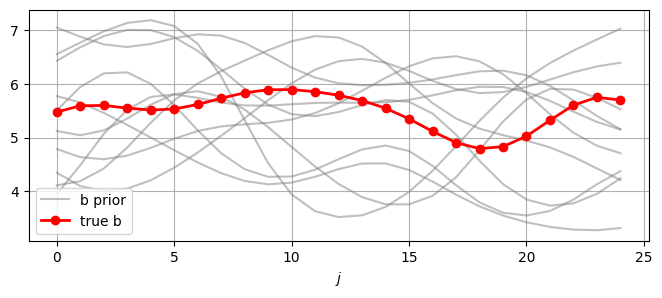

In [2]:
import matplotlib.pyplot as plt
import numpy as np

bw = np.load("./data/bw.npy")
b_true = np.load("./data/b_true.npy")

fig, ax = plt.subplots(1, 1, figsize=(8,3), sharex=True)
ax.plot(bw, color='gray', alpha=0.5)
ax.plot(b_true, color='red', linewidth=2, marker="o")
ax.plot([], color='gray', alpha=0.5, label="b prior")
ax.plot([], color='red', linewidth=2, label="true b", marker="o")
ax.legend()
ax.set_xlabel("$j$")
plt.grid()
plt.show()

## Get all data

In [ ]:
socp_Sw_traj = np.load("./data/socp_Sw_traj.npy")
socp_qt = np.load("./data/socp_qocp.npy")

wse_Sw_traj = np.load("./data/wse_Sw_traj.npy")
wse_qt = np.load("./data/wse_qmpc.npy")

nse_Sw_traj = np.load("./data/nse_Sw_traj.npy")
nse_qt = np.load("./data/nse_qmpc.npy")

nse_cc_Sw_traj = np.load("./data/nse_cc_Sw_traj.npy")
nse_cc_qt = np.load("./data/nse_cc_qmpc.npy")

notc_5_Sw_traj = np.load("./data/notc_5_Sw_traj.npy")
notc_5_qt = np.load("./data/smpc_notc_5_qmpc.npy")

notc_10_Sw_traj = np.load("./data/notc_10_Sw_traj.npy")
notc_10_qt = np.load("./data/notc_10_qmpc.npy")

notc_20_Sw_traj = np.load("./data/notc_20_Sw_traj.npy")
notc_20_qt = np.load("./data/notc_20_qmpc.npy")

aw = 20.0
bw = np.load(f"./data/bw.npy")
socp_qwt, socp_qot, socp_swt, socp_costt, socp_fwt = get_flow_rate(socp_Sw_traj, socp_qt, aw, bw)
wse_qwt, wse_qot, wse_swt, wse_costt, wse_fwt = get_flow_rate(wse_Sw_traj, wse_qt, aw, bw)
nse_qwt, nse_qot, nse_swt, nse_costt, nse_fwt = get_flow_rate(nse_Sw_traj, nse_qt, aw, bw)
nse_cc_qwt, nse_cc_qot, nse_cc_swt, nse_cc_costt, nse_cc_fwt = get_flow_rate(nse_Sw_traj, nse_cc_qt, aw, bw)
notc_5_qwt, notc_5_qot, notc_5_swt, notc_5_costt, notc_5_fwt = get_flow_rate(notc_5_Sw_traj, notc_5_qt, aw, bw)
notc_10_qwt, notc_10_qot, notc_10_swt, notc_10_costt, notc_10_fwt = get_flow_rate(notc_10_Sw_traj, notc_10_qt, aw, bw)
notc_20_qwt, notc_20_qot, notc_20_swt, notc_20_costt, notc_20_fwt = get_flow_rate(notc_20_Sw_traj, notc_20_qt, aw, bw)

## plot solutions

There are two parts:
1. Comparison of SMPC without terminal cost for K_mpc = [5, 10, 20]
1. Comparison of SMPC with and without model update

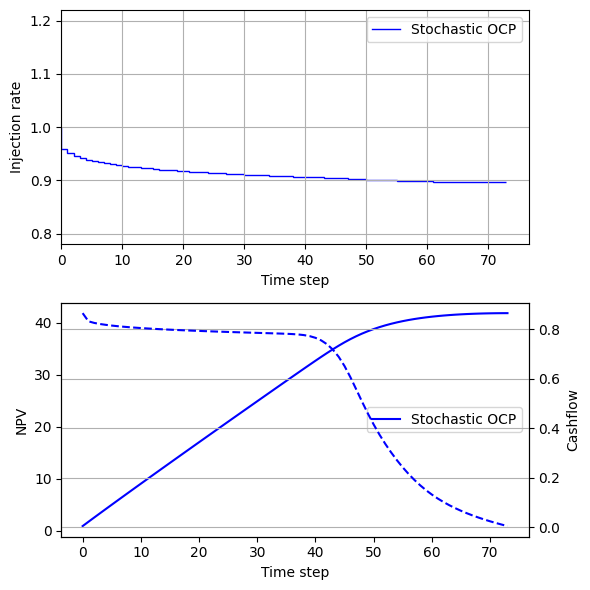

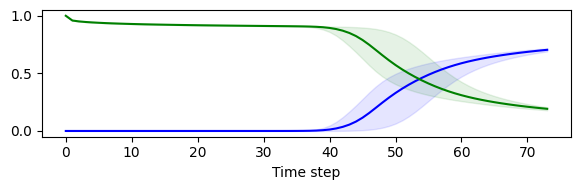

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].stairs(range(len(socp_qt)-1), socp_qt, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_xlabel("Time step")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid(True)
ax[1].plot(-np.mean(np.cumsum(socp_costt, axis=0), axis=1), color='blue')
ax[1].plot([], color='blue', label="Stochastic OCP")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
ax1.plot(-np.mean(socp_costt, axis=1), color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_socp_cost.png")
plt.show()

Nt = len(socp_qwt)
fig, ax = plt.subplots(figsize=(6,2), sharex=True)
ax.plot(np.mean(socp_qwt, axis=1), label="water rate", color="blue")
ax.fill_between(range(Nt), np.percentile(socp_qwt, 5, axis=1), np.percentile(socp_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax.plot(np.mean(socp_qot, axis=1), label="oil rate", color="green")
ax.fill_between(range(Nt), np.percentile(socp_qot, 5, axis=1), np.percentile(socp_qot, 95, axis=1),  color="green", alpha=0.1)

ax.set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_socp_fluidprofile.png")
plt.show()

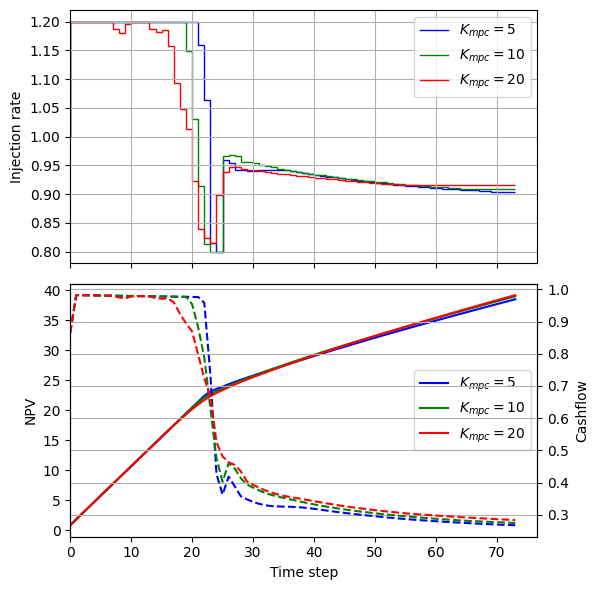

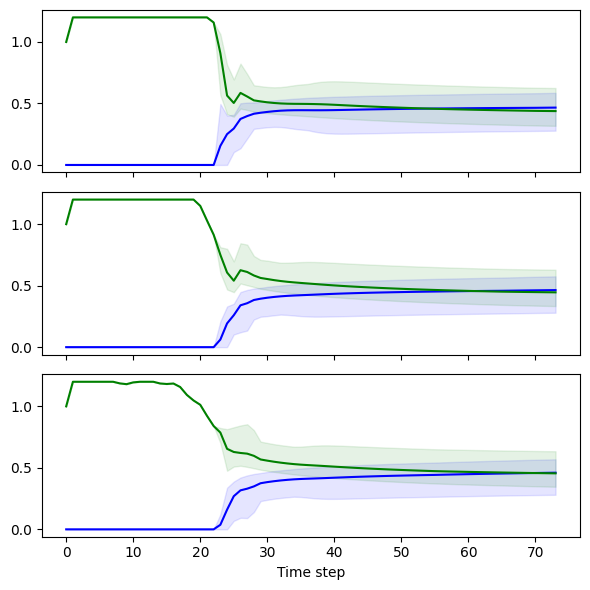

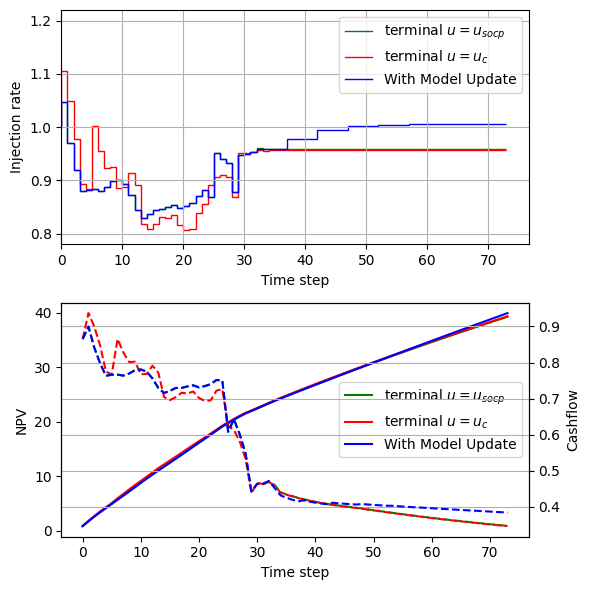

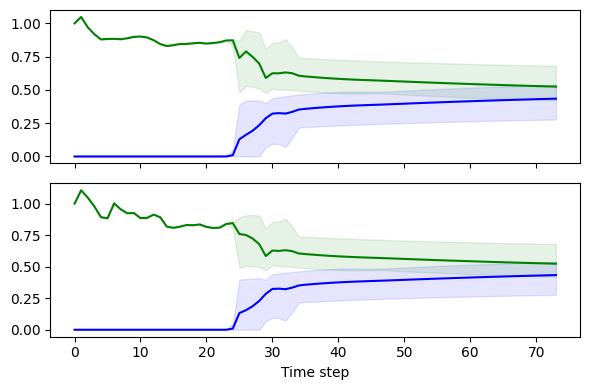

In [5]:
## Comparison of SMPC without terminal cost
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
ax[0].stairs(range(len(notc_5_qt)-1), notc_5_qt, label="$K_{mpc} = 5$", color="blue", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(notc_10_qt)-1), notc_10_qt, label="$K_{mpc} = 10$", color="green", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(notc_20_qt)-1), notc_20_qt, label="$K_{mpc} = 20$", color="red", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid()
ax[1].plot(-np.mean(np.cumsum(notc_5_costt, axis=0), axis=1), color='blue')
ax[1].plot(-np.mean(np.cumsum(notc_10_costt, axis=0), axis=1), color='green')
ax[1].plot(-np.mean(np.cumsum(notc_20_costt, axis=0), axis=1), color='red')
ax[1].plot([], color='blue', label="$K_{mpc} = 5$")
ax[1].plot([], color='green', label="$K_{mpc} = 10$")
ax[1].plot([], color='red', label="$K_{mpc} = 20$")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
ax1.plot(-np.mean(notc_5_costt, axis=1), color="blue", linestyle="dashed")
ax1.plot(-np.mean(notc_10_costt, axis=1), color="green", linestyle="dashed")
ax1.plot(-np.mean(notc_20_costt, axis=1), color="red", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_notc_cost.png")


Nt = len(notc_5_qwt)
fig, ax = plt.subplots(3,1,figsize=(6,6), sharex=True)
ax[0].plot(np.mean(notc_5_qwt, axis=1), label="water rate", color="blue")
ax[0].fill_between(range(Nt), np.percentile(notc_5_qwt, 5, axis=1), np.percentile(notc_5_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[0].plot(np.mean(notc_5_qot, axis=1), label="oil rate", color="green")
ax[0].fill_between(range(Nt), np.percentile(notc_5_qot, 5, axis=1), np.percentile(notc_5_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].plot(np.mean(notc_10_qwt, axis=1), label="water rate", color="blue")
ax[1].fill_between(range(Nt), np.percentile(notc_10_qwt, 5, axis=1), np.percentile(notc_10_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[1].plot(np.mean(notc_10_qot, axis=1), label="oil rate", color="green")
ax[1].fill_between(range(Nt), np.percentile(notc_10_qot, 5, axis=1), np.percentile(notc_10_qot, 95, axis=1),  color="green", alpha=0.1)

ax[2].plot(np.mean(notc_20_qwt, axis=1), label="water rate", color="blue")
ax[2].fill_between(range(Nt), np.percentile(notc_20_qwt, 5, axis=1), np.percentile(notc_20_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[2].plot(np.mean(notc_20_qot, axis=1), label="oil rate", color="green")
ax[2].fill_between(range(Nt), np.percentile(notc_20_qot, 5, axis=1), np.percentile(notc_20_qot, 95, axis=1),  color="green", alpha=0.1)
ax[2].set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_notc_fluidprofile.png")
plt.show()




# fig.tight_layout()
# plt.savefig("./data/results_notc_fluid_profiles.png")

## Comparison of SMPC with and without model update
fig, ax = plt.subplots(2, 1, figsize=(6,6))
# ax.stairs(range(len(socp_qt)-1), socp_qt, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(nse_qt)-1), nse_qt, label="terminal $u = u_{socp}$", color="green", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(nse_cc_qt)-1), nse_cc_qt, label="terminal $u = u_c$", color="red", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(wse_qt)-1), wse_qt, label="With Model Update", color="blue", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_xlabel("Time step")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid(True)
ax[1].plot(-np.mean(np.cumsum(nse_costt, axis=0), axis=1), color='green')
ax[1].plot(-np.mean(np.cumsum(nse_cc_costt, axis=0), axis=1), color='red')
ax[1].plot(-np.mean(np.cumsum(wse_costt, axis=0), axis=1), color='blue')
# ax.plot([], color='blue', label="Stochastic OCP")
ax[1].plot([], color='green', label="terminal $u = u_{socp}$")
ax[1].plot([], color='red', label="terminal $u = u_c$")
ax[1].plot([], color='blue', label="With Model Update")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
# ax1.plot(-np.mean(socp_costt, axis=1), color="blue", linestyle="dashed")
ax1.plot(-np.mean(nse_costt, axis=1), color="green", linestyle="dashed")
ax1.plot(-np.mean(nse_cc_costt, axis=1), color="red", linestyle="dashed")
ax1.plot(-np.mean(wse_costt, axis=1), color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_tc_cost.png")
plt.show()

Nt = len(notc_5_qwt)
fig, ax = plt.subplots(2,1,figsize=(6,4), sharex=True)
ax[0].plot(np.mean(nse_qwt, axis=1), label="water rate", color="blue")
ax[0].fill_between(range(Nt), np.percentile(nse_qwt, 5, axis=1), np.percentile(nse_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[0].plot(np.mean(nse_qot, axis=1), label="oil rate", color="green")
ax[0].fill_between(range(Nt), np.percentile(nse_qot, 5, axis=1), np.percentile(nse_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].plot(np.mean(nse_cc_qwt, axis=1), label="water rate", color="blue")
ax[1].fill_between(range(Nt), np.percentile(nse_cc_qwt, 5, axis=1), np.percentile(nse_cc_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[1].plot(np.mean(nse_cc_qot, axis=1), label="oil rate", color="green")
ax[1].fill_between(range(Nt), np.percentile(nse_cc_qot, 5, axis=1), np.percentile(nse_cc_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_tc_fluidprofile.png")
plt.show()


## plot prior vs posterior vs true parameters

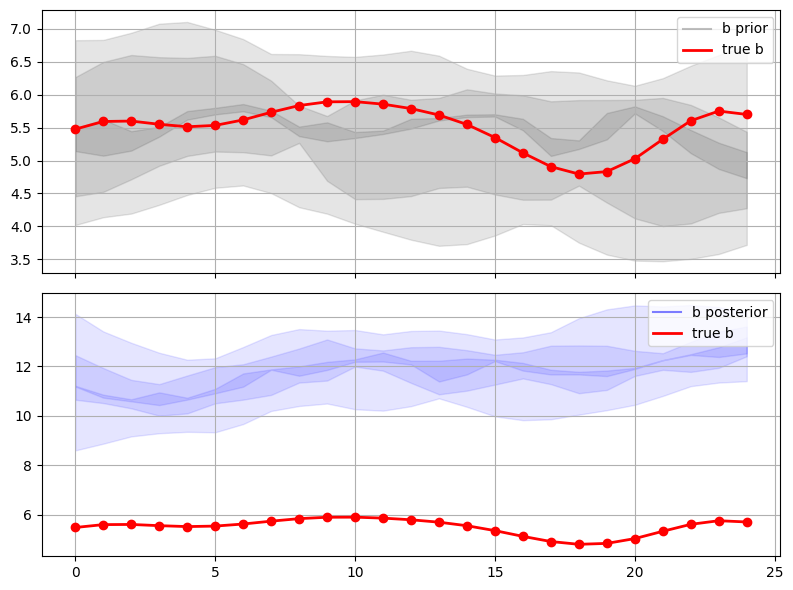

In [6]:
bw_traj = np.load("./data/wse_bw_traj.npy")
bw = np.load("./data/bw.npy")
b_true = np.load("./data/b_true.npy")

xrange = range(bw.shape[0])
post_bw5 = np.percentile(bw_traj[-1], 5, axis=1)
post_bw95 = np.percentile(bw_traj[-1], 95, axis=1)
post_bw25 = np.percentile(bw_traj[-1], 25, axis=1)
post_bw75 = np.percentile(bw_traj[-1], 75, axis=1)
post_bw45 = np.percentile(bw_traj[-1], 45, axis=1)
post_bw55 = np.percentile(bw_traj[-1], 55, axis=1)

prior_bw5 = np.percentile(bw, 5, axis=1)
prior_bw95 = np.percentile(bw, 95, axis=1)
prior_bw25 = np.percentile(bw, 25, axis=1)
prior_bw75 = np.percentile(bw, 75, axis=1)
prior_bw45 = np.percentile(bw, 45, axis=1)
prior_bw55 = np.percentile(bw, 55, axis=1)


fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
# ax.plot(bw, color='gray', alpha=0.5)
# ax.plot(bw_traj[-1], color='blue', alpha=0.5)

ax[0].fill_between(xrange, prior_bw5, prior_bw95, color="black", alpha=0.1)
ax[0].fill_between(xrange, prior_bw25, prior_bw75, color="black", alpha=0.1)
ax[0].fill_between(xrange, prior_bw45, prior_bw55, color="black", alpha=0.1)
ax[1].fill_between(xrange, post_bw5, post_bw95, color="blue", alpha=0.1)
ax[1].fill_between(xrange, post_bw25, post_bw75, color="blue", alpha=0.1)
ax[1].fill_between(xrange, post_bw45, post_bw55, color="blue", alpha=0.1)


ax[0].plot(b_true, color='red', linewidth=2, marker="o")
ax[1].plot(b_true, color='red', linewidth=2, marker="o")
ax[0].plot([], color='gray', alpha=0.5, label="b prior")
ax[1].plot([], color='blue', alpha=0.5, label="b posterior")
ax[0].plot([], color='red', linewidth=2, label="true b")
ax[1].plot([], color='red', linewidth=2, label="true b")

# ax[0].set_ylim(5, 21)
# ax[1].set_ylim(5, 21)

ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
fig.tight_layout()
plt.savefig(f"./data/results_prior_post_bw.png")
plt.show()

## Evaluate on the true model

In [7]:
nx = 25
Swinit = [1.0] + [0.2]*(nx-1)
## true model
aw = 100.0
bw = np.load("./data/b_true.npy")[:,np.newaxis]
Ne = 1

true_socp_cost = calculate_cost(Swinit, socp_qt, aw, bw, Ne, nx)
true_wse_cost = calculate_cost(Swinit, wse_qt, aw, bw, Ne, nx)
true_nse_cost = calculate_cost(Swinit, nse_qt, aw, bw, Ne, nx)
true_nse_cc_cost = calculate_cost(Swinit, nse_cc_qt, aw, bw, Ne, nx)
true_notc_5_cost = calculate_cost(Swinit, notc_5_qt, aw, bw, Ne, nx)
true_notc_10_cost = calculate_cost(Swinit, notc_10_qt, aw, bw, Ne, nx)
true_notc_20_cost = calculate_cost(Swinit, notc_20_qt, aw, bw, Ne, nx)


bw = np.load("./data/bw.npy")
Ne = 10
SwinitNe = np.array([Swinit]*Ne).flatten()
prior_wse_cost = -calculate_cost(SwinitNe, wse_qt, aw, bw, Ne, nx)

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), SX(q_10), SX(q_11), SX(q_12), SX(q_13), SX(q_14), SX(q_15), SX(q_16), SX(q_17), SX(q_18), SX(q_19), SX(q_20), SX(q_21), SX(q_22), SX(q_23), SX(q_24), SX(q_25), SX(q_26), SX(q_27), SX(q_28), SX(q_29), SX(q_30), SX(q_31), SX(q_32), SX(q_33), SX(q_34), SX(q_35), SX(q_36), SX(q_37), SX(q_38), SX(q_39), SX(q_40), SX(q_41), SX(q_42), SX(q_43), SX(q_44), SX(q_45), SX(q_46), SX(q_47), SX(q_48), SX(q_49), SX(q_50), SX(q_51), SX(q_52), SX(q_53), SX(q_54), SX(q_55), SX(q_56), SX(q_57), SX(q_58), SX(q_59), SX(q_60), SX(q_61), SX(q_62), SX(q_63), SX(q_64), SX(q_65), SX(q_66), SX(q_67), SX(q_68), SX(q_69), SX(q_70), SX(q_71), SX(q_72), SX(q_73)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), SX(q_10), SX(q_11), SX(q_12), SX(q_13), SX(q_14), SX(q_15), SX(q_16), SX(q_17), SX

In [8]:
def cumulative(cost):
    return np.cumsum(cost, axis=0)


# plt.plot(cumulative(true_socp_cost))
# plt.plot(cumulative(true_wse_cost))
# plt.plot(cumulative(true_nse_cost))
# plt.plot(cumulative(true_nse_cc_cost))
# plt.plot(cumulative(true_notc_5_cost))
# plt.plot(cumulative(true_notc_10_cost))
# plt.plot(cumulative(true_notc_20_cost))

cost_list = [(true_notc_5_cost, notc_5_costt),
             (true_notc_10_cost, notc_10_costt),
             (true_notc_20_cost, notc_20_costt),
             (true_nse_cc_cost, nse_cc_costt), 
             (true_nse_cost, nse_costt),
             (true_wse_cost, prior_wse_cost)]

print(f"Case & True NPV & Expected NPV & SD NPV \\\\\\hline")
for i, cost in enumerate(cost_list):
    print(f"Case {i+1} & {cumulative(cost[0])[-1,0]:.6g} & {-np.mean(cumulative(cost[1])[-1]):.6g} & {np.std(cumulative(cost[1])[-1]):.4g} \\\\")
    

Case & True NPV & Expected NPV & SD NPV \\\hline
Case 1 & 50.8751 & 38.471 & 5.4 \\
Case 2 & 51.0827 & 38.9593 & 5.24 \\
Case 3 & 51.3933 & 39.1623 & 5.064 \\
Case 4 & 52.8152 & 39.317 & 4.712 \\
Case 5 & 52.8594 & 39.239 & 4.732 \\
Case 6 & 52.5478 & 52.2324 & 0.7038 \\


In [9]:
bw = np.load(f"./data/bw.npy")
socp_qwt, socp_qot, socp_swt, socp_costt, socp_fwt = get_flow_rate(socp_Sw_traj, socp_qt, bw)

bw = np.load("./data/b_true.npy")[:,np.newaxis]
true_socp_cost = calculate_cost(Swinit, socp_qt, aw, bw, Ne, nx)

TypeError: get_flow_rate() missing 1 required positional argument: 'bw'